In [1]:
#%reset -f
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np
import feather
import time
import h2oaiglm as h2oaiglm


Loaded H2OAIGLM CPU library

Loaded H2OAIGLM GPU library.


In [2]:
%matplotlib inline
import psutil
from py3nvml.py3nvml import *

import pandas as pd
import numpy as np
import time
import os

import pylab as pl
from IPython import display
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

In [3]:
import os
import time
import sys
import subprocess
from concurrent.futures import ProcessPoolExecutor
maxNGPUS = int(subprocess.check_output("nvidia-smi -L | wc -l", shell=True))
print("Maximum Number of GPUS:", maxNGPUS)

nvmlInit()
deviceCount = nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvmlDeviceGetHandleByIndex(i)
    print("Device {}: {}".format(i, nvmlDeviceGetName(handle)))
print ("Driver Version:", nvmlSystemGetDriverVersion())

Maximum Number of GPUS: 2
Device 0: b'GeForce GTX 980 Ti'
Device 1: b'TITAN X (Pascal)'
Driver Version: b'375.20'


### Import Data Frame and create raw X and y arrays

In [4]:
# Run: cd ~/h2oai-prototypes/ ; gunzip ipums.csv.gz ; R -f ipums_feather.R ; rm -rf ipums.csv ; git checkout ipums.csv.gz
t0 = time.time()
from os.path import expanduser
home = str(expanduser("~"))
filepostfix="/h2oai-prototypes/glm-bench/ipums.feather"
df = feather.read_dataframe(home+filepostfix)
t1 = time.time()
print("Time to read data via feather: %r" % (t1-t0))

Time to read data via feather: 1.432535171508789


In [5]:
target = df.columns[-1] ## last column is the response
cols = [c for c in df.columns if c != target]

In [6]:
X = np.array(df.ix[:,cols], order='f').astype('float32')
y = np.array(df[target].values, dtype='float32')
print(X.shape)
print(y.shape)

(55776, 9732)
(55776,)


### H2O AI GLM using the GPU Pointers

In [7]:
intercept = 1
validFraction=0.2
standardize = 0
lambda_min_ratio = 1e-7

if standardize:
    print ("implement standardization transformer")
    exit()

# Setup Train/validation Set Split
morig = X.shape[0]
norig = X.shape[1]
print("Original m=%d n=%d" % (morig,norig))
fortran = X.flags.f_contiguous
print("fortran=%d" % (fortran))

# Do train/valid split
HO=int(validFraction*morig)
H=morig-HO
print("Size of Train rows=%d valid rows=%d" % (H,HO))
trainX = np.copy(X[0:H,:])
trainY = np.copy(y[0:H])
validX = np.copy(X[H:-1,:])
validY = np.copy(y[H:-1])
trainW = np.copy(trainY)*0.0 + 1.0 # constant unity weight

mTrain = trainX.shape[0]
mvalid = validX.shape[0]
print("mTrain=%d mvalid=%d" % (mTrain,mvalid))

if intercept==1:
    trainX = np.hstack([trainX, np.ones((trainX.shape[0],1),dtype=trainX.dtype)])
    validX = np.hstack([validX, np.ones((validX.shape[0],1),dtype=validX.dtype)])
    n = trainX.shape[1]
    print("New n=%d" % (n))

Original m=55776 n=9732
fortran=1
Size of Train rows=44621 valid rows=11155
mTrain=44621 mvalid=11154
New n=9733


In [8]:
def plot_cpu_perf(axis, cpu_labels, cpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(cpu_labels, cpu_snapshot, color='dodgerblue')
    axis.set_title('CPU Utilization', fontsize = 16)
    
def plot_gpu_perf(axis, gpu_labels, gpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_xticks(gpu_labels)
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(gpu_labels, gpu_snapshot, width =0.5, color = 'limegreen')
    axis.set_title('GPU Utilization', fontsize = 16)
    
def plot_glm_results(axis, results, best_rmse, cb):
    axis.cla()
    axis.set_xscale('log')
    axis.set_xlim([.01, 1e9])
    axis.set_ylim([-0.08, 1.08])
    axis.set_ylabel('Parameter 1:  '+r'$\alpha$', fontsize = 16)
    axis.set_xlabel('Parameter 2:  '+r'$\lambda$', fontsize = 16)
    axis.set_title('Elastic Net Regularization Paths', fontsize = 16)
    try:
        cm = ListedColormap(sns.color_palette("RdYlGn", 10).as_hex())
        cf = axis.scatter(results['lambda'], results['alpha'], c=results['rel_acc'], 
                    cmap=cm, vmin=0, vmax=1)
        axis.plot(best_rmse['lambda'],best_rmse['alpha'], 'o',
            ms=15, mec='k', mfc='none', mew=2)

        if not cb:
            cb = pl.colorbar(cf, ax=axis)
            cb.set_label('Relative  Validation  Accuracy', rotation=270, 
                         labelpad=18, fontsize = 16)   
        cb.update_normal(cf)
    except:
        #print("plot_glm_results exception -- no frame")
        pass

In [9]:
def RunH2Oaiglm(arg):
    intercept,standardize, lambda_min_ratio, nFolds, nAlphas, nLambdas, nGPUs = arg
    # set solver cpu/gpu according to input args
    if((nGPUs>0) and (h2oaiglm.ElasticNetSolverGPU is None)):
        print("\nGPU solver unavailable, using CPU solver\n")
        nGPUs=0

    sharedA = 0
    sourceme = 0
    sourceDev = 0
    nThreads = 1 if(nGPUs==0) else nGPUs # not required number of threads, but normal.  Bit more optimal to use 2 threads for CPU, but 1 thread per GPU is optimal.

    print("Setting up Solver")
    os.system("rm -f rmse.txt ; touch rmse.txt ; rm -f varimp.txt ; touch varimp.txt") ## for visualization
    Solver = h2oaiglm.ElasticNetSolverGPU if(nGPUs>0) else h2oaiglm.ElasticNetSolverCPU
    #  Solver = h2oaiglm.ElasticNetSolverCPU
    assert Solver != None, "Couldn't instantiate ElasticNetSolver"
    enet = Solver(sharedA, nThreads, nGPUs, 'c' if fortran else 'r', intercept, standardize, lambda_min_ratio, nLambdas, nFolds, nAlphas)


    ## First, get backend pointers
    t0 = time.time()
    a,b,c,d,e = enet.upload_data(sourceDev, trainX, trainY, validX, validY, trainW)
    t1 = time.time()
    print("Time to ingest data: %r" % (t1-t0))


    ## Solve
    print("Solving")
    t0 = time.time()
    enet.fit(sourceDev, mTrain, n, mvalid, intercept, standardize, a, b, c, d, e)
    t1 = time.time()
    print("Done Solving")
    print("Time to train H2O AI GLM: %r" % (t1-t0))

In [10]:
def RunAnimation(arg):
    deviceCount, file = arg
        
    fig = pl.figure(figsize = (9,9))
    pl.rcParams['xtick.labelsize'] = 14
    pl.rcParams['ytick.labelsize'] = 14
    gs = gridspec.GridSpec(3, 2, wspace=0.3, hspace=0.4)
    ax1 = pl.subplot(gs[0,-2])
    ax2 = pl.subplot(gs[0,1])
    ax3 = pl.subplot(gs[1:,:])
    fig.suptitle('H2O.ai Machine Learning $-$ Generalized Linear Modeling', size=18)

    pl.gcf().subplots_adjust(bottom=0.2)

    cb = False
    os.system("mkdir -p images")
    i=0
    while(True):
        try:
            #cpu
            snapshot = psutil.cpu_percent(percpu=True)
            cpu_labels = range(1,len(snapshot)+1)
            plot_cpu_perf(ax1, cpu_labels, snapshot)
    
            #gpu
            gpu_snapshot = []
            gpu_labels = list(range(1,deviceCount+1))
            for j in range(deviceCount):
                handle = nvmlDeviceGetHandleByIndex(j)
                util = nvmlDeviceGetUtilizationRates(handle)
                gpu_snapshot.append(util.gpu)
            gpu_snapshot = gpu_snapshot   
            plot_gpu_perf(ax2, gpu_labels, gpu_snapshot)
    
            res = pd.read_csv(file, sep="\s+",header=None,names=['time','pass','fold','a','i','alpha','lambda','trainrmse','ivalidrmse','validrmse'])
            
            res['rel_acc'] = ((42665- res['validrmse'])/(42665-31000))
            best = res.ix[res['rel_acc']==np.max(res['rel_acc']),:]
            plot_glm_results(ax3, res, best.tail(1), cb)
            # flag for colorbar to avoid redrawing
            cb = True

            # Add footnotes
            footnote_text = "*U.S. Census dataset (predict Income): 45k rows, 10k cols\nParameters: 5-fold cross-validation, " + r'$\alpha = \{\frac{i}{7},i=0\ldots7\}$' + ", "\
   'full $\lambda$-' + "search"
            #pl.figtext(.05, -.04, footnote_text, fontsize = 14,)
            pl.annotate(footnote_text, (0,0), (-30, -50), fontsize = 12,
                        xycoords='axes fraction', textcoords='offset points', va='top')

            #update the graphics
            display.display(pl.gcf())
            display.clear_output(wait=True)
            time.sleep(0.01)

            #save the images
            saveimage=0
            if saveimage:
                file_name = './images/glm_run_%04d.png' % (i,)
                pl.savefig(file_name, dpi=200)
            i=i+1
        
        except KeyboardInterrupt:
            break
        except:
            #print("Could not Create Frame")
            pass

In [14]:
Executor = ProcessPoolExecutor(max_workers=1)

lambda_min_ratio=1E-9
nFolds=5
nAlphas=5
nLambdas=100
nGPUs=0 #maxNGPUS  # or can chose less

arg = intercept,standardize, lambda_min_ratio, nFolds, nAlphas, nLambdas, nGPUs 
futures = []
futures.append(Executor.submit(RunH2Oaiglm, arg))

Setting up Solver
Detected np.float32
c_void_p(139628979744784)
c_void_p(468547904)
c_void_p(1521241184)
c_void_p(485792464)
c_void_p(468726400)
Time to ingest data: 0.5228338241577148
Solving


DoneAndNotDoneFutures(done={<Future at 0x7effa0166320 state=finished raised TypeError>}, not_done=set())

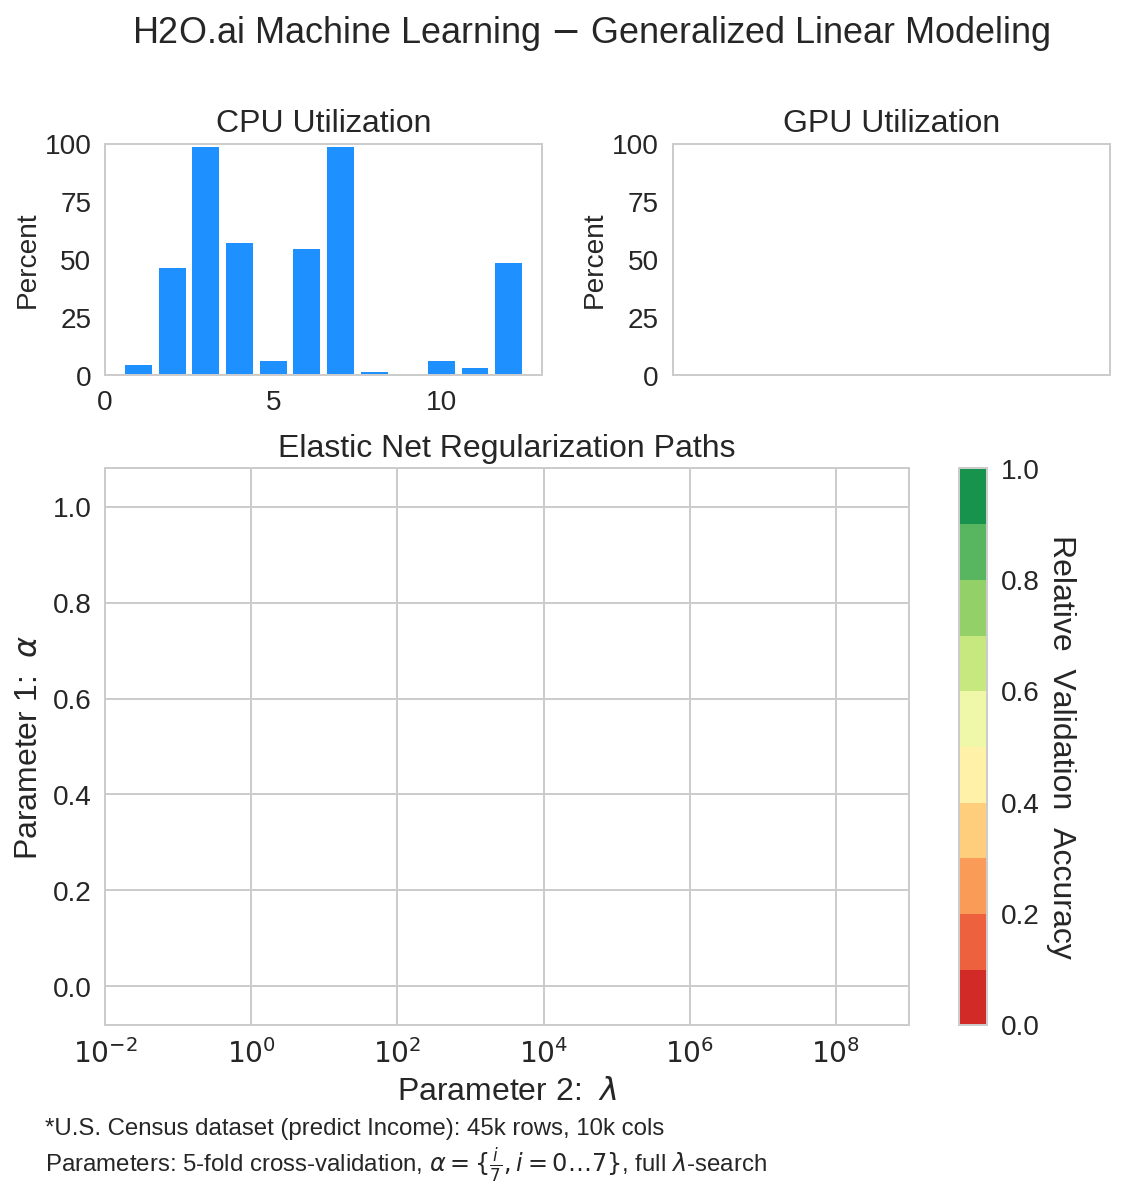

In [15]:
import os
path=os.getcwd()
arg = nGPUs, path + "/rmse.txt"

RunAnimation(arg)

import concurrent.futures
concurrent.futures.wait(futures)